# Manifold learning

In this notebook, we implement various manifold learning techniques on a simple dataset.

Our goal is to see
- how to use existing libraries to perform manifold learning algorithms
- how the different algorithms produce different results

In [2]:
import numpy as np
from typing import Tuple, List
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
np.random.seed(5206)

## The swiss roll dataset

The swiss roll dataset is a popular toy problem in manifold learning.

![Swiss Roll](https://upload.wikimedia.org/wikipedia/commons/d/da/Sri_Lankan_Swiss_roll.jpg)

We generate data resembling a swiss roll via a parametric equation
$$
\begin{aligned}
    x &= \frac{1}{6} (\phi + \text{noise}) \sin(\phi) \\
    y &= \frac{1}{6} (\phi + \text{noise}) \cos(\phi) \\
    z &\sim U[0, L_z] \text{ and } \phi \sim U[0, L_\phi]
\end{aligned}
$$

In [3]:
# Set parameters
length_phi = 15   # Length of swiss roll in angular direction
length_Z = 15     # Length of swiss roll in z direction
sigma = 0.1       # Noise strength
m = 8192          # Number of samples

# Create dataset
phi = length_phi * np.random.rand(m)
xi = np.random.rand(m)
z = length_Z * np.random.rand(m)
x = 1./6 * (phi + sigma * xi) * np.sin(phi)
y = 1./6 * (phi + sigma * xi) * np.cos(phi)

X = np.array([x, y, z]).transpose()

color = phi  # color the data according to the angular direction

In [5]:
phi.shape

(8192,)

In [3]:
X.shape

(8192, 3)

Text(0.5, 0.92, 'Swiss roll dataset')

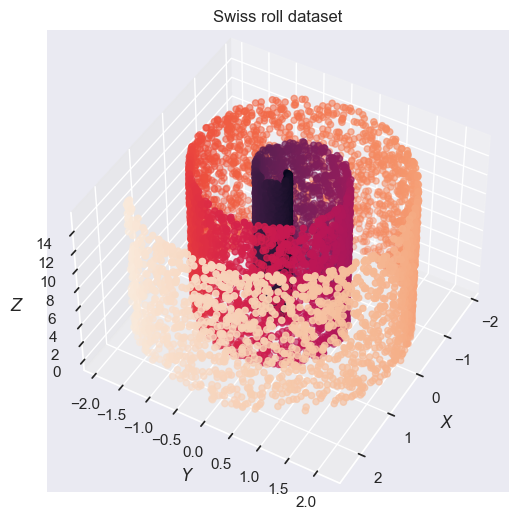

In [6]:
# Create the plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=45, azim=30)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color)
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$Y$')
ax.set_zlabel(r'$Z$')
ax.set_title('Swiss roll dataset')

Note the following:
- The dataset is in 3D
- The manifold (the swiss roll) is a 2D surface embedded in 3D
- The colour shown is a "coordinate" on this 2D surface

The goal of manifold learning is to find an embedding so that the "coordinate" color can be correlated to the embedded space.

Thus, a good "principal component" will be on that varies continuously with the color gradient!

## Linear PCA

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca = PCA(n_components=2)  # we shall just plot the top 2 components
X_pca = pca.fit_transform(X)

Let us plot the scores for the top two components...

Text(0.5, 1.0, 'Scatter plot of PCA component scores')

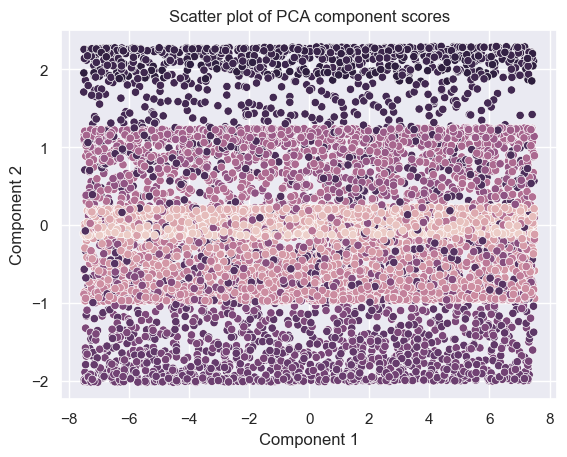

In [9]:
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=color, legend=False)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Scatter plot of PCA component scores')

In [10]:
X_pca.shape,phi.shape

((8192, 2), (8192,))

We see that when projected to this 2D space, the manifold structure is *not* sufficiently captured.

In particular, points very far on the manifold have very close projections!

## Kernel PCA

Now, we try kernel PCA with the RBF kernel to see if we can do better.

In [8]:
from sklearn.decomposition import KernelPCA

In [9]:
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=1.0)
X_kpca = kpca.fit_transform(X)

Here, we use the RBF kernel with parameter `gamma` ($\gamma$), i.e.
$$
    k(x,x') = \exp
    \left[
        - \frac{|x-x'|^2}{2\gamma^2}
    \right]
$$
In practice, $\gamma$ has to be tuned for best results (say with cross validation).

Text(0.5, 1.0, 'Scatter plot of kernel PCA component scores')

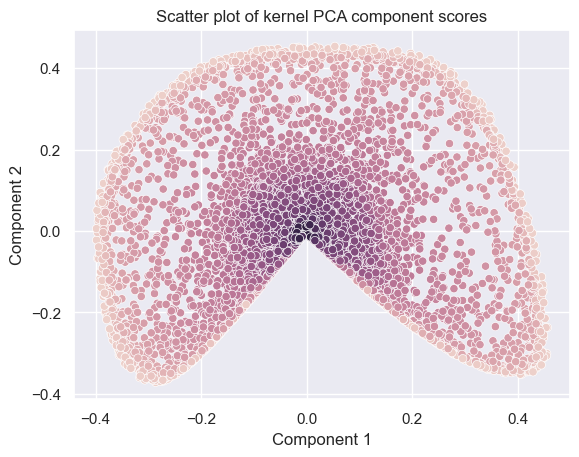

In [10]:
sns.scatterplot(x=X_kpca[:, 0], y=X_kpca[:, 1], hue=color, legend=False)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Scatter plot of kernel PCA component scores')

Observe that this is an improvement to the linear PCA, but still still not satisfactory!

Of course, the choice of kernels are very important
- can you test some different kernels?
- can you think of constructing a kernel that works well?

## Locally linear embedding

Now, let us apply locally linear embedding.

We can see that for this problem, if we pick a moderate number of nearest neighbours, the linear structure can capture much of the manifold's geometry!

In [11]:
from sklearn.manifold import LocallyLinearEmbedding

In [12]:
lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2, method='standard')
X_lle = lle.fit_transform(X)

Here we pick 10 nearest neighbours. 

Text(0.5, 1.0, 'Scatter plot of LLE components')

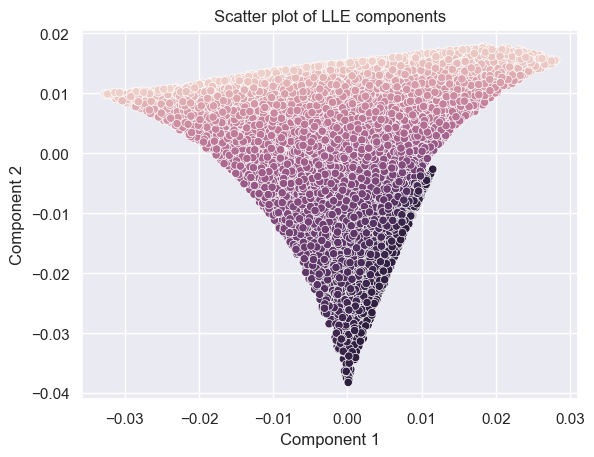

In [13]:
sns.scatterplot(x=X_lle[:, 0], y=X_lle[:, 1], hue=color, legend=False)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Scatter plot of LLE components')

Observe that LLE is quite effective for this problem, and the two components map out much of the manifold.

However, do note that the choice of the number of nearest neighbours is important!
- Can you see why?
- Test it!

## Diffusion map

`sklearn` currently does not support diffusion maps, but we can use another implementation `pyDiffMap`.

You can read about it [here](https://pydiffmap.readthedocs.io/en/master/readme.html).

You can install this package by
```shell
pip install pyDiffMap
```

In [16]:
from pydiffmap import diffusion_map as dm

In [17]:
dmap = dm.DiffusionMap.from_sklearn(n_evecs=2, k=200, epsilon='bgh', alpha=0.0)
X_dmap = dmap.fit_transform(X)

Some parameters are worth noting
- `k` is the number of nearest neighbours to construct the kernel (and hence the transition matrix). This is supposed to be num_data-points, but we can save computation by having fewer points
- `alpha` is an optional scaling parameter. Setting to 0 reduces to the simplest construction of the transition matrix, but in practice this should be tuned. Try it!

Text(0.5, 1.0, 'Scatter plot of diffusion map components')

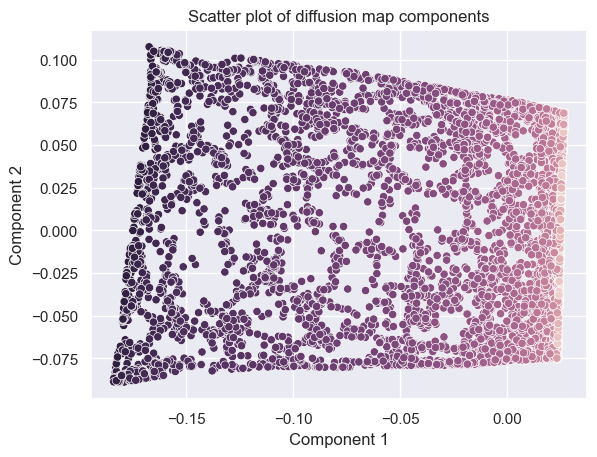

In [18]:
sns.scatterplot(x=X_dmap[:, 0], y=X_dmap[:, 1], hue=color, legend=False)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Scatter plot of diffusion map components')

We can see that the manifold structure is well preserved - with component 1 similar to the angular coordinate and component 2 the perpendicular direction of the swiss roll.

## Summary

In this notebook, we played around with various manifold learning (non-linear dimensionality reduction) techniques, and compared them on the simple swiss roll dataset.

Exercise
- Play around with the various hyper-parameters (read the docs!), if you use these techniques for your project, you will need to tune these parameters.
- Can you try these methods on a more realistic dataset, say MNIST, FashionMNIST or something even more complicated? What are some computational issues one may encounter?